<a href="https://colab.research.google.com/github/mytimeyinji/yinji/blob/master/Alexnet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from tensorflow.keras import layers, models, Model, Sequential


def AlexNet_v1(im_height=224, im_width=224, class_num=1000):
    # tensorflow中的tensor通道排序是NHWC
    input_image = layers.Input(shape=(im_height, im_width, 3), dtype="float32")  # output(None, 224, 224, 3)
    x = layers.ZeroPadding2D(((1, 2), (1, 2)))(input_image)                      # output(None, 227, 227, 3)
    x = layers.Conv2D(48, kernel_size=11, strides=4, activation="relu")(x)       # output(None, 55, 55, 48)
    x = layers.MaxPool2D(pool_size=3, strides=2)(x)                              # output(None, 27, 27, 48)
    x = layers.Conv2D(128, kernel_size=5, padding="same", activation="relu")(x)  # output(None, 27, 27, 128)
    x = layers.MaxPool2D(pool_size=3, strides=2)(x)                              # output(None, 13, 13, 128)
    x = layers.Conv2D(192, kernel_size=3, padding="same", activation="relu")(x)  # output(None, 13, 13, 192)
    x = layers.Conv2D(192, kernel_size=3, padding="same", activation="relu")(x)  # output(None, 13, 13, 192)
    x = layers.Conv2D(128, kernel_size=3, padding="same", activation="relu")(x)  # output(None, 13, 13, 128)
    x = layers.MaxPool2D(pool_size=3, strides=2)(x)                              # output(None, 6, 6, 128)

    x = layers.Flatten()(x)                         # output(None, 6*6*128)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(2048, activation="relu")(x)    # output(None, 2048)
    x = layers.Dropout(0.2)(x)
    x = layers.Dense(2048, activation="relu")(x)    # output(None, 2048)
    x = layers.Dense(class_num)(x)                  # output(None, 5)
    predict = layers.Softmax()(x)

    model = models.Model(inputs=input_image, outputs=predict)
    return model


class AlexNet_v2(Model):
    def __init__(self, class_num=1000):
        super(AlexNet_v2, self).__init__()
        self.features = Sequential([
            layers.ZeroPadding2D(((1, 2), (1, 2))),                                 # output(None, 227, 227, 3)
            layers.Conv2D(48, kernel_size=11, strides=4, activation="relu"),        # output(None, 55, 55, 48)
            layers.MaxPool2D(pool_size=3, strides=2),                               # output(None, 27, 27, 48)
            layers.Conv2D(128, kernel_size=5, padding="same", activation="relu"),   # output(None, 27, 27, 128)
            layers.MaxPool2D(pool_size=3, strides=2),                               # output(None, 13, 13, 128)
            layers.Conv2D(192, kernel_size=3, padding="same", activation="relu"),   # output(None, 13, 13, 192)
            layers.Conv2D(192, kernel_size=3, padding="same", activation="relu"),   # output(None, 13, 13, 192)
            layers.Conv2D(128, kernel_size=3, padding="same", activation="relu"),   # output(None, 13, 13, 128)
            layers.MaxPool2D(pool_size=3, strides=2)])                              # output(None, 6, 6, 128)

        self.flatten = layers.Flatten()
        self.classifier = Sequential([
            layers.Dropout(0.2),
            layers.Dense(1024, activation="relu"),                                  # output(None, 2048)
            layers.Dropout(0.2),
            layers.Dense(128, activation="relu"),                                   # output(None, 2048)
            layers.Dense(class_num),                                                # output(None, 5)
            layers.Softmax()
        ])

    def call(self, inputs, **kwargs):
        x = self.features(inputs)
        x = self.flatten(x)
        x = self.classifier(x)
        return x

Found 3306 images belonging to 5 classes.
Found 364 images belonging to 5 classes.
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 227, 227, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 55, 55, 48)        17472     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 27, 27, 48)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 27, 27, 128)       153728    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 13, 13, 128)       0         
____________________________________________

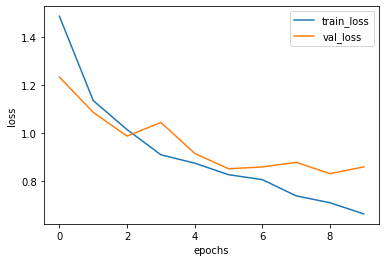

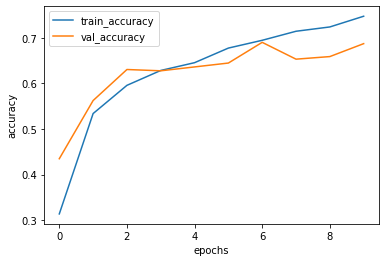

In [7]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import tensorflow as tf
import json
import os

data_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))  # get data root path
image_path = data_root + "/content/data_set/flower_data/"  # flower data set path
train_dir = image_path + "train"
validation_dir = image_path + "val"

# create direction for saving weights
if not os.path.exists("save_weights"):
    os.makedirs("save_weights")

im_height = 224
im_width = 224
batch_size = 32
epochs = 10

# data generator with data augmentation
train_image_generator = ImageDataGenerator(rescale=1. / 255,
                                           horizontal_flip=True)
validation_image_generator = ImageDataGenerator(rescale=1. / 255)

train_data_gen = train_image_generator.flow_from_directory(directory=train_dir,
                                                           batch_size=batch_size,
                                                           shuffle=True,
                                                           target_size=(im_height, im_width),
                                                           class_mode='categorical')
total_train = train_data_gen.n

# get class dict
class_indices = train_data_gen.class_indices

# transform value and key of dict
inverse_dict = dict((val, key) for key, val in class_indices.items())
# write dict into json file
json_str = json.dumps(inverse_dict, indent=4)
with open('/class_indices.json', 'w') as json_file:
    json_file.write(json_str)

val_data_gen = validation_image_generator.flow_from_directory(directory=validation_dir,
                                                              batch_size=batch_size,
                                                              shuffle=False,
                                                              target_size=(im_height, im_width),
                                                              class_mode='categorical')
total_val = val_data_gen.n

# sample_training_images, sample_training_labels = next(train_data_gen)  # label is one-hot coding
#
#
# # This function will plot images in the form of a grid with 1 row and 5 columns where images are placed in each column.
# def plotImages(images_arr):
#     fig, axes = plt.subplots(1, 5, figsize=(20, 20))
#     axes = axes.flatten()
#     for img, ax in zip(images_arr, axes):
#         ax.imshow(img)
#         ax.axis('off')
#     plt.tight_layout()
#     plt.show()
#
#
# plotImages(sample_training_images[:5])

model = AlexNet_v1(im_height=im_height, im_width=im_width, class_num=5)
# model = AlexNet_v2(class_num=5)
# model.build((batch_size, 224, 224, 3))  # when using subclass model
model.summary()

# using keras high level api for training
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
              metrics=["accuracy"])

callbacks = [tf.keras.callbacks.ModelCheckpoint(filepath='./save_weights/myAlex.h5',
                                                save_best_only=True,
                                                save_weights_only=True,
                                                monitor='val_loss')]

# tensorflow2.1 recommend to using fit
history = model.fit(x=train_data_gen,
                    steps_per_epoch=total_train // batch_size,
                    epochs=epochs,
                    validation_data=val_data_gen,
                    validation_steps=total_val // batch_size,
                    callbacks=callbacks)

# plot loss and accuracy image
history_dict = history.history
train_loss = history_dict["loss"]
train_accuracy = history_dict["accuracy"]
val_loss = history_dict["val_loss"]
val_accuracy = history_dict["val_accuracy"]

# figure 1
plt.figure()
plt.plot(range(epochs), train_loss, label='train_loss')
plt.plot(range(epochs), val_loss, label='val_loss')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')

# figure 2
plt.figure()
plt.plot(range(epochs), train_accuracy, label='train_accuracy')
plt.plot(range(epochs), val_accuracy, label='val_accuracy')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.show()


# history = model.fit_generator(generator=train_data_gen,
#                               steps_per_epoch=total_train // batch_size,
#                               epochs=epochs,
#                               validation_data=val_data_gen,
#                               validation_steps=total_val // batch_size,
#                               callbacks=callbacks)

# # using keras low level api for training
# loss_object = tf.keras.losses.CategoricalCrossentropy(from_logits=False)
# optimizer = tf.keras.optimizers.Adam(learning_rate=0.0005)
#
# train_loss = tf.keras.metrics.Mean(name='train_loss')
# train_accuracy = tf.keras.metrics.CategoricalAccuracy(name='train_accuracy')
#
# test_loss = tf.keras.metrics.Mean(name='test_loss')
# test_accuracy = tf.keras.metrics.CategoricalAccuracy(name='test_accuracy')
#
#
# @tf.function
# def train_step(images, labels):
#     with tf.GradientTape() as tape:
#         predictions = model(images, training=True)
#         loss = loss_object(labels, predictions)
#     gradients = tape.gradient(loss, model.trainable_variables)
#     optimizer.apply_gradients(zip(gradients, model.trainable_variables))
#
#     train_loss(loss)
#     train_accuracy(labels, predictions)
#
#
# @tf.function
# def test_step(images, labels):
#     predictions = model(images, training=False)
#     t_loss = loss_object(labels, predictions)
#
#     test_loss(t_loss)
#     test_accuracy(labels, predictions)
#
#
# best_test_loss = float('inf')
# for epoch in range(1, epochs+1):
#     train_loss.reset_states()        # clear history info
#     train_accuracy.reset_states()    # clear history info
#     test_loss.reset_states()         # clear history info
#     test_accuracy.reset_states()     # clear history info
#     for step in range(total_train // batch_size):
#         images, labels = next(train_data_gen)
#         train_step(images, labels)
#
#     for step in range(total_val // batch_size):
#         test_images, test_labels = next(val_data_gen)
#         test_step(test_images, test_labels)
#
#     template = 'Epoch {}, Loss: {}, Accuracy: {}, Test Loss: {}, Test Accuracy: {}'
#     print(template.format(epoch,
#                           train_loss.result(),
#                           train_accuracy.result() * 100,
#                           test_loss.result(),
#                           test_accuracy.result() * 100))
#     if test_loss.result() < best_test_loss:
#        model.save_weights("./save_weights/myAlex.ckpt", save_format='tf')



tulips 0.8303569


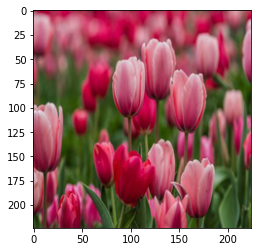

In [14]:
from PIL import Image
import numpy as np
import json
import matplotlib.pyplot as plt

im_height = 224
im_width = 224

# load image
img = Image.open("/cai0.jpg")
# resize image to 224x224
img = img.resize((im_width, im_height))
plt.imshow(img)

# scaling pixel value to (0-1)
img = np.array(img) / 255.

# Add the image to a batch where it's the only member.
img = (np.expand_dims(img, 0))

# read class_indict
try:
    json_file = open('/class_indices.json', 'r')
    class_indict = json.load(json_file)
except Exception as e:
    print(e)
    exit(-1)

model = AlexNet_v1(class_num=5)
model.load_weights("./save_weights/myAlex.h5")
result = np.squeeze(model.predict(img))
predict_class = np.argmax(result)
print(class_indict[str(predict_class)], result[predict_class])
plt.show()



In [15]:
!tar -zcvf /home/cai.tar.gz /content/save_weights/myAlex.h5 

tar: Removing leading `/' from member names
/content/save_weights/myAlex.h5


In [0]:
from google.colab import files

files.download('/home/cai.tar.gz')


In [5]:
!unzip /data_set.zip

流式输出内容被截断，只能显示最后 5000 行内容。
 extracting: data_set/flower_data/flower_photos/sunflowers/200557981_f800fa1af9.jpg  
 extracting: data_set/flower_data/flower_photos/sunflowers/200557983_10a88672fc.jpg  
  inflating: data_set/flower_data/flower_photos/sunflowers/20078409301_aa8061bd0b_n.jpg  
 extracting: data_set/flower_data/flower_photos/sunflowers/20148493928_9f75a99783.jpg  
  inflating: data_set/flower_data/flower_photos/sunflowers/20156280765_a6baea3176.jpg  
  inflating: data_set/flower_data/flower_photos/sunflowers/20171662239_f69b6c12bd_n.jpg  
 extracting: data_set/flower_data/flower_photos/sunflowers/201809908_0ef84bb351.jpg  
  inflating: data_set/flower_data/flower_photos/sunflowers/20183028616_beb937e75c_m.jpg  
  inflating: data_set/flower_data/flower_photos/sunflowers/20183071136_c297e74fcc_m.jpg  
  inflating: data_set/flower_data/flower_photos/sunflowers/20258015499_93b9951800_m.jpg  
  inflating: data_set/flower_data/flower_photos/sunflowers/20342824594_9740b7b160.jpg  
 